# Implementation of Episodic Semi-Gradient SARSA on MountainCar-v0

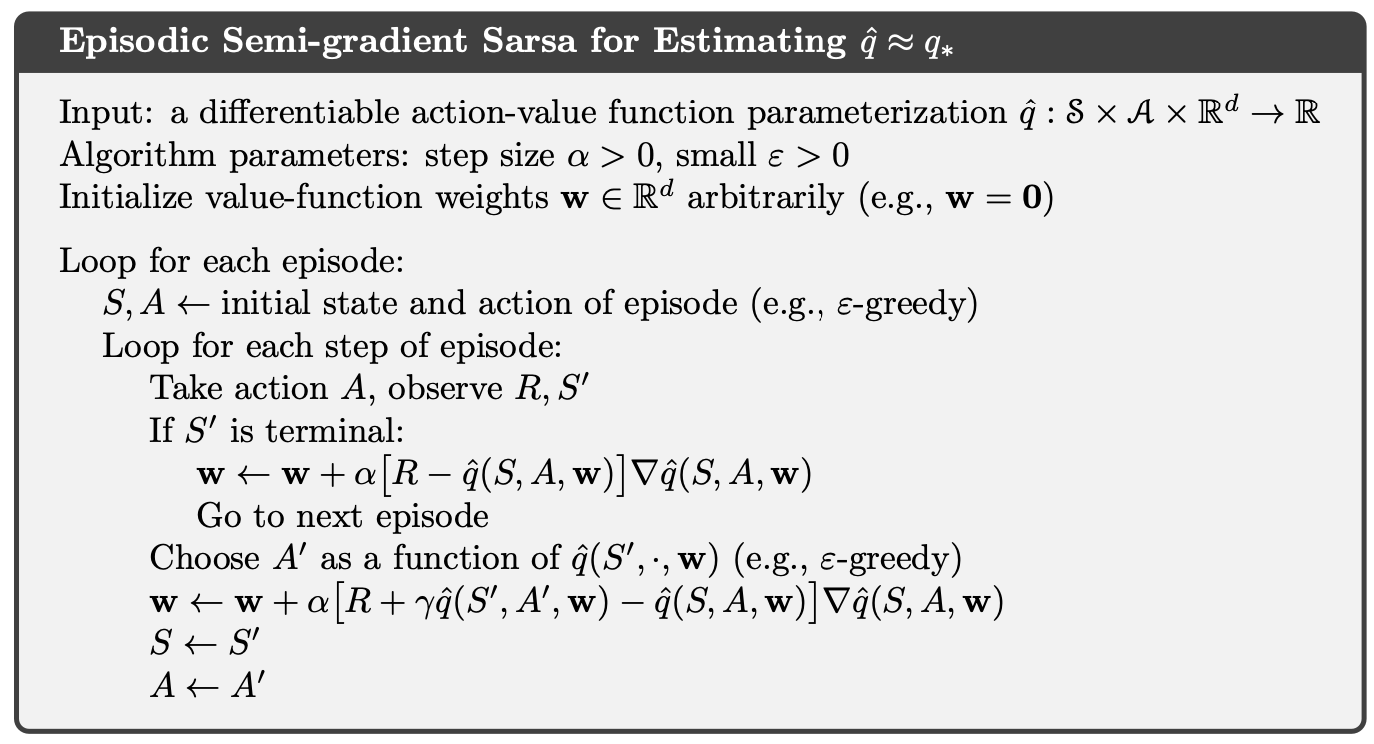